### Florian Muthreich   ---   INF368   ---

# Assignment 1

load necessary packages

In [23]:
import matplotlib.pyplot as plt
import keras
import random

Next I download the MNIST dataset. It is already split in test and training set and saved to variables. The images are stored separately from the labels in arrays.

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


The MNIST set has been downloaded and I can show the dimensions of the dataset.
In total there are 70000 images of handwritten numbers. 60000 in the train set and 10000 in the test set. each image is 28 x 28 pixels and has only one channel, which means each cell indicates the intensity of a pixel. The labels are stored separately in their own array, which basically has the shape of a vector.

In [32]:
print("Training set:",x_train.shape, ", labels", y_train.shape)
print("Test set:",x_test.shape, ", labels", y_test.shape)

Training set: (60000, 28, 28) , labels (60000,)
Test set: (10000, 28, 28) , labels (10000,)


Here I plot 6 random images from the MNIST dataset. 3 from the train and 3 from the test set.

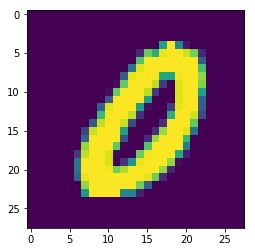

Train-set img: 42091 label : 0


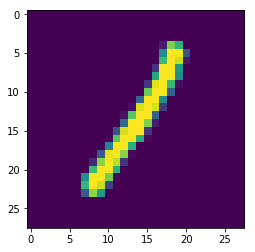

Train-set img: 51767 label : 1


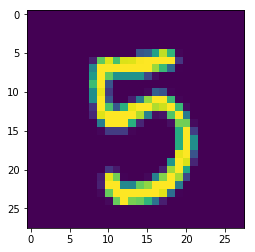

Train-set img: 30323 label : 5


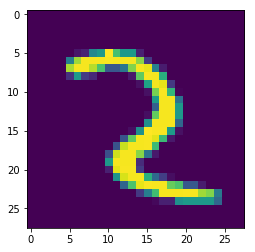

Test-set img: 3832 label : 2


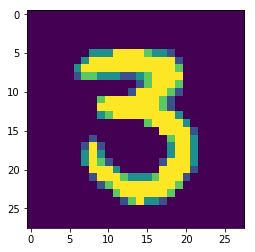

Test-set img: 5273 label : 3


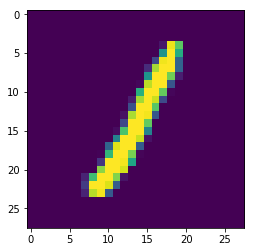

Test-set img: 6729 label : 1


In [31]:
for x in range(6):
    if x<3:
        i = random.randint(1,x_train.shape[0])
        img = plt.imshow(x_train[i])
        plt.show()
        print("Train-set img:", i, "label :", y_train[i])
    else:
        i = random.randint(1,x_test.shape[0])
        img = plt.imshow(x_test[i])
        plt.show()
        print("Test-set img:", i, "label :", y_test[i])